# Test Notebook

## Test saving and continuing training

In [2]:
from __future__ import division
from IPython.display import clear_output
# imports to run OpenAI Gym in Jupyter
import gym
import gym.spaces
import gym_gvgai
import matplotlib.pyplot as plt
from IPython import display

# how to render in Jupyter: 
# https://stackoverflow.com/questions/40195740/how-to-run-openai-gym-render-over-a-server
# https://www.youtube.com/watch?v=O84KgRt6AJI
def show_state(env, step=0, name='', info=''):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Step: %d %s" % (name, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())
    
# transforms the state into what the tpg agent can use.
def getState(state):
    state2 = []
    for x in state:
        for y in x:
            state2.append(y[0]/8 + y[1]*4 + y[2]*128)
            
    return state2

# run agent in function to work with multiprocessing
def runAgent(agenteqsq):
    agent = agenteqsq[0] # get agent
    eq = agenteqsq[1] # get environment queue
    sq = agenteqsq[2] # get score queue
    
    # check if agent already has score
    if agent.taskDone():
        print('Agent #' + str(agent.getAgentNum()) + ' can skip.')
        sq.put((agent.getUid(), agent.getOutcomes()))
        return
        
    print('envs in queue:',eq.qsize())
    env = eq.get() # get an environment
    state = env.reset() # get initial state and prep environment
    
    valActs = range(env.action_space.n)
    
    score = 0
    for i in range(1000): # run episodes that last 200 frames
        act = agent.act(getState(state), valActs=valActs) # get action from agent

        # feedback from env
        state, reward, isDone, debug = env.step(act)
        score += reward # accumulate reward in score
        if isDone:
            break # end early if losing state
            
    agent.reward(score) # must reward agent
    
    print('Agent #' + str(agent.getAgentNum()) + ' finished with score ' + str(score))
    sq.put((agent.getUid(), agent.getOutcomes())) # get outcomes with id
    eq.put(env) # put environment back

In [2]:
%matplotlib inline
import time # for tracking time
from tpg.tpg_trainer import TpgTrainer
import pickle

env = gym.make('Assault-v0') # make the environment

trainer = TpgTrainer(actions=range(env.action_space.n), teamPopSizeInit=30)

tStart = time.time()

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

# 5 generations isn't much (not even close), but some improvements
# should be seen.
for gen in range(3): # generation loop
    curScores = [] # new list per gen
    
    while True: # loop to go through agents
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        # check if agent already has score
        if agent.taskDone():
            score = agent.getOutcome()
        else:
            state = env.reset() # get initial state and prep environment
            score = 0
            for i in range(50): # run episodes that last 200 frames

                act = agent.act(getState(state)) # get action from agent

                # feedback from env
                state, reward, isDone, debug = env.step(act)
                score += reward # accumulate reward in score
                if isDone:
                    break # end early if losing state

            agent.reward(score) # must reward agent (if didn't already score)
            
        print('Agent got score', score)
        curScores.append(score) # store score
            
    # at end of generation, make summary of scores
    summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    trainer.evolve()
    clear_output(wait=True)
    
clear_output(wait=True) 
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results:\nMin, Max, Avg')
for result in summaryScores:
    print(result[0],result[1],result[2])
    
print(trainer.generateScoreStats())
    
# save the model
with open('test-model.pkl','wb') as f:
    pickle.dump(trainer,f)

Time Taken (Seconds): 32.36272954940796
Results:
Min, Max, Avg
0.0 42.0 3.5
0.0 42.0 4.5
0.0 42.0 6.461538461538462
{'scores': [0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 42.0, 21.0, 21.0, 42.0, 21.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'min': 0.0, 'max': 42.0, 'average': 7.0}


In [5]:
# test reobtaining file
with open('test-model.pkl','rb') as f:
    trainer = pickle.load(f)
    
print(trainer.generateScoreStats())

{'scores': [0.0, 0.0, 0.0, 0.0, 21.0, 0.0, 0.0, 42.0, 21.0, 21.0, 42.0, 21.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'min': 0.0, 'max': 42.0, 'average': 7.0}


In [6]:
# make sure can continue training
tStart = time.time()

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

# 5 generations isn't much (not even close), but some improvements
# should be seen.
for gen in range(3): # generation loop
    curScores = [] # new list per gen
    
    while True: # loop to go through agents
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        # check if agent already has score
        if agent.taskDone():
            score = agent.getOutcome()
        else:
            state = env.reset() # get initial state and prep environment
            score = 0
            for i in range(50): # run episodes that last 200 frames

                act = agent.act(getState(state)) # get action from agent

                # feedback from env
                state, reward, isDone, debug = env.step(act)
                score += reward # accumulate reward in score
                if isDone:
                    break # end early if losing state

            agent.reward(score) # must reward agent (if didn't already score)
            
        print('Agent got score', score)
        curScores.append(score) # store score
            
    # at end of generation, make summary of scores
    summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    trainer.evolve()
    clear_output(wait=True)
    
clear_output(wait=True) 
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results:\nMin, Max, Avg')
for result in summaryScores:
    print(result[0],result[1],result[2])
    
print(trainer.generateScoreStats())

Time Taken (Seconds): 20.191575288772583
Results:
Min, Max, Avg
0.0 42.0 8.75
0.0 42.0 11.375
0.0 42.0 17.181818181818183
{'scores': [21.0, 42.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 42.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'min': 0, 'max': 42.0, 'average': 12.409090909090908}


## Test GVGAI Env

KeyboardInterrupt: 

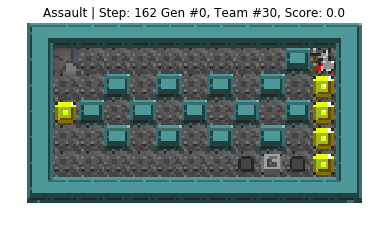

In [6]:
%matplotlib inline
import time # for tracking time
from tpg.tpg_trainer import TpgTrainer
import pickle

env = gym.make('gvgai-testgame3-lvl0-v0') # make the environment

trainer = TpgTrainer(actions=range(env.action_space.n), teamPopSizeInit=30)

tStart = time.time()

curScores = [] # hold scores in a generation
summaryScores = [] # record score summaries for each gen (min, max, avg)

# 5 generations isn't much (not even close), but some improvements
# should be seen.
for gen in range(3): # generation loop
    curScores = [] # new list per gen
    
    while True: # loop to go through agents
        teamNum = trainer.remainingAgents()
        agent = trainer.getNextAgent()
        if agent is None:
            break # no more agents, so proceed to next gen
        
        # check if agent already has score
        if agent.taskDone():
            score = agent.getOutcome()
        else:
            state = env.reset() # get initial state and prep environment
            score = 0
            for i in range(2000): # run episodes that last 200 frames
                show_state(env, i, 'Assault', 'Gen #' + str(gen) + 
                           ', Team #' + str(teamNum) +
                           ', Score: ' + str(score)) # render env

                act = agent.act(getState(state)) # get action from agent

                # feedback from env
                state, reward, isDone, debug = env.step(act)
                score += reward # accumulate reward in score
                if isDone:
                    break # end early if losing state

            agent.reward(score) # must reward agent (if didn't already score)
            
        print('Agent got score', score)
        curScores.append(score) # store score
            
    # at end of generation, make summary of scores
    summaryScores.append((min(curScores), max(curScores),
                    sum(curScores)/len(curScores))) # min, max, avg
    trainer.evolve()
    clear_output(wait=True)
    
clear_output(wait=True) 
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results:\nMin, Max, Avg')
for result in summaryScores:
    print(result[0],result[1],result[2])
    
print(trainer.generateScoreStats())
    
# save the model
with open('test-model.pkl','wb') as f:
    pickle.dump(trainer,f)

In [13]:
env = gym.make('gvgai-testgame1-lvl0-v0') # make the environment
print(env.action_space)
env = gym.make('gvgai-testgame2-lvl0-v0') # make the environment
print(env.action_space)
env = gym.make('gvgai-testgame3-lvl0-v0') # make the environment
print(env.action_space)
print(str(env.env))

Connecting to host 127.0.0.1 at port 47053 ...
Client connected to server [OK]
Discrete(6)
Connecting to host 127.0.0.1 at port 37309 ...
Client connected to server [OK]
Discrete(6)
Connecting to host 127.0.0.1 at port 47219 ...
Client connected to server [OK]
Discrete(5)
<GVGAI_Env<gvgai-testgame3-lvl0-v0>>


## Test multigame playing with multiprocessing

In [2]:
import time
import random
from tpg.tpg_trainer import TpgTrainer
from tpg.tpg_agent import TpgAgent
import pickle
import multiprocessing as mp

tStart = time.time()

lock = mp.Lock()
processes = 4 # how many to run concurrently (4 is best for my local desktop)
m = mp.Manager()

allGames = ['gvgai-testgame1-lvl0-v0','gvgai-testgame1-lvl1-v0',
            'gvgai-testgame2-lvl0-v0','gvgai-testgame2-lvl0-v0',
            'gvgai-testgame3-lvl0-v0','gvgai-testgame3-lvl1-v0']
allGames = ['Assault-v0']

envs = {}
for game in allGames:
    envs[game] = []
    for p in range(processes): # each process needs its own environment
        envs[game].append(gym.make(game))
        
gameQueue = list(allGames)
random.shuffle(gameQueue)
    
trainer = TpgTrainer(actions=range(6), teamPopSizeInit=360)

pool = mp.Pool(processes=processes)
    
summaryScores = [] # record score summaries for each gen (min, max, avg) 
    
for gen in range(100): # generation loop
    scoreQueue = m.Queue() # hold agents when finish, to actually apply score
    envQueue = m.Queue() # hold envs for current gen
    
    # get right env in envQueue
    game = gameQueue.pop() # take out last game
    for p in range(processes):
        envQueue.put(envs[game][p])
    # re-get games list
    if len(gameQueue) == 0:
        gameQueue = list(allGames)
        random.shuffle(gameQueue)
        
    # tasks = [str(envs[game][0].env)]
    
    # run generation
    # skipTasks=[] so we get all agents, even if already scored,
    # just to report the obtained score for all agents.
    pool.map(runAgent, 
                 [(agent, envQueue, scoreQueue) 
                  for agent in trainer.getAllAgents(skipTasks=[])])
    
    scores = [] # convert scores into list
    while not scoreQueue.empty():
        scores.append(scoreQueue.get())
    if len(scores) == 0:
        print('wtf this is bs')
        x = 1/0
    
    # apply scores
    trainer.applyScores(scores)
    trainer.evolve() # go into next gen
    
    # save model after every gen
    with open('gvgai-model-1.pkl','wb') as f:
        pickle.dump(trainer,f)

    # at end of generation, make summary of scores
    summaryScores.append((trainer.scoreStats['min'], 
                    trainer.scoreStats['max'],
                    trainer.scoreStats['average'])) # min, max, avg
    
    clear_output(wait=True)
    print('Time Taken (Seconds): ' + str(time.time() - tStart))
    print('Results so far: ' + str(summaryScores))
    
clear_output(wait=True)
print('Time Taken (Seconds): ' + str(time.time() - tStart))
print('Results: ' + str(summaryScores))

envs in queue: 4
envs in queue: 3
envs in queue: 2
envs in queue: 1
envs in queue: 0
envs in queue: 0
envs in queue: 0
envs in queue: 0


Process ForkPoolWorker-3:
Process ForkPoolWorker-4:
Process ForkPoolWorker-2:
Process ForkPoolWorker-5:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ryan/anaconda3/envs/oaigym3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ryan/anaconda3/envs/oaigym3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ryan/anaconda3/envs/oaigym3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ryan/anaconda3/envs/oaigym3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ryan/anaconda3/envs/oaigym3/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/home/ryan/anaconda3/envs/oaigym3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstra

KeyboardInterrupt: 

  File "/home/ryan/anaconda3/envs/oaigym3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
  File "/home/ryan/anaconda3/envs/oaigym3/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/ryan/anaconda3/envs/oaigym3/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


## Testing some wild thing down here! Watch out!!!!